## SQLite and PostgreSQL Persistence - Production Ready Memory
### Save Conversations

Learning Objectives:
 - Understand MemorySaver vs SqliteSaver
 - Save conversations that survive restarts
 - Handle multiple users with thread isolation

#### Real-World Use Cases:
 1. **Production Chatbots**: Survive server restarts
 2. **Customer Support**: Persistent conversation history
 3. **Personal Assistants**: Remember across sessions
 4. **Recovery**: Resume after crashes

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.postgres import PostgresSaver

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
import os

# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [3]:
## Tool usage
import sys
sys.path.append("../05. LangGraph ReAct Agent with Tools")

import my_tools

# my_tools.get_weather.invoke({'location': "Mumbai"})

my_tools.calculate.invoke({'expression': '2+2*1.4/23-34'})

all_tools = [my_tools.get_weather, my_tools.calculate]

[TOOL] calculate ('2+2*1.4/23-34') -> '-31.878260869565217'


In [4]:
# Create Agent State
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

In [5]:
## Agent Node

def agent_node(state: AgentState):

    llm_with_tools = llm.bind_tools(all_tools)

    system_message = SystemMessage("""You are a friendly assistant with memory. 
                                   Use the availale tools to help the user when needed.
                                   
                                   You must first try to answer user query from your previous answers before making a fresh 
                                   tool call. Do not make answers by yourself if you are not sure.""")

    messages = [system_message] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] Responding...")


    return {'messages': [response]}

In [6]:
state = {"messages": [HumanMessage("Hi")]}
result = agent_node(state)
result

[AGENT] Responding...


{'messages': [AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T15:28:07.20388Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5024679200, 'load_duration': 3323103600, 'prompt_eval_count': 513, 'prompt_eval_duration': 120042500, 'eval_count': 94, 'eval_duration': 1530393600, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--8c0b6c5e-2b55-4be5-bf3c-eab870018a3f-0', usage_metadata={'input_tokens': 513, 'output_tokens': 94, 'total_tokens': 607})]}

In [7]:
# Routing
def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return END

In [8]:
# =============================================================================
# Graph
# =============================================================================
def create_agent(checkpointer):

    builder = StateGraph(AgentState)

    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode(all_tools))


    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", should_continue, ["tools", END])

    builder.add_edge("tools", "agent")

    graph = builder.compile(checkpointer=checkpointer)

    return graph

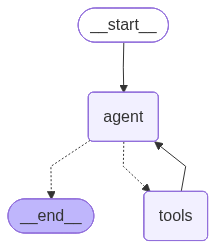

In [9]:
checkpointer = MemorySaver()
agent = create_agent(checkpointer)
agent

### Memory Persistence in SQLite Memory

In [10]:
import sqlite3
import os

os.makedirs('db', exist_ok=True)

db_path = "db/checkpoints.db"

conn = sqlite3.connect(db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn)


In [11]:
def chat(agent, query, thread_id):

    config = {"configurable": {"thread_id": thread_id}}

    for chunk in agent.stream({'messages': [query]}, config=config):

        if 'agent' in chunk:
            chunk = chunk.get('agent')
        else:
            chunk = chunk.get('tools')

        if hasattr(chunk, 'tool_calls') and chunk.tool_calls:
            for tc in chunk.tool_calls:
                print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
        else:
            print(f"[AGENT/ToolMessage] Responding.\n{chunk['messages'][0].content}")

        # print(chunk)        




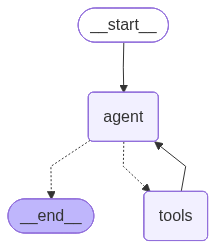

In [12]:
agent = create_agent(checkpointer)
agent

In [13]:
query = "What is the current weather in New Delhi?"
chat(agent, query, "laxmikant")

[AGENT] Responding...
[AGENT/ToolMessage] Responding.
The current weather in New Delhi is **25°C (78°F)** with **haze**. The latest observation shows clear skies with light winds (10 km/h), but some hourly data indicates sunny periods. However, the weather description includes "haze," which might affect visibility. For the most accurate and up-to-date information, consider checking a real-time weather service. 🌤️


### Memory Persistence in PostgreSQL

In [ ]:
# https://console.neon.tech/

In [14]:
import psycopg

conn = psycopg.connect(os.getenv("POSTGRESQL_URL"), autocommit=True, prepare_threshold=0)

checkpointer = PostgresSaver(conn)

In [16]:
# setup for first time.
checkpointer.setup()

In [17]:
agent = create_agent(checkpointer)

query = "What is the current weather in New Delhi?"
chat(agent, query, "laxmikant")

[AGENT] called Tool get_weather with args {'location': 'New Delhi'}
[AGENT/ToolMessage] Responding.

[AGENT/ToolMessage] Responding.
{"current_condition": [{"FeelsLikeC": "23", "FeelsLikeF": "74", "cloudcover": "25", "humidity": "61", "localObsDateTime": "2025-11-05 09:28 PM", "observation_time": "03:58 PM", "precipInches": "0.0", "precipMM": "0.0", "pressure": "1011", "pressureInches": "30", "temp_C": "24", "temp_F": "76", "uvIndex": "0", "visibility": "3", "visibilityMiles": "1", "weatherCode": "143", "weatherDesc": [{"value": "Haze"}], "weatherIconUrl": [{"value": ""}], "winddir16Point": "WNW", "winddirDegree": "294", "windspeedKmph": "9", "windspeedMiles": "6"}], "nearest_area": [{"areaName": [{"value": "New Delhi"}], "country": [{"value": "India"}], "latitude": "28.600", "longitude": "77.200", "population": "10928270", "region": [{"value": "Delhi"}], "weatherUrl": [{"value": ""}]}], "request": [{"query": "Lat 28.61 and Lon 77.22", "type": "LatLon"}], "weather": [{"astronomy": [{"m

#### Method 2 for PostgreSQL connection

In [18]:
with PostgresSaver.from_conn_string(os.getenv("POSTGRESQL_URL")) as checkpointer:
    agent = create_agent(checkpointer)

    query = "what is 2 + 2?"
    chat(agent, query, "laxmikant")

[AGENT] called Tool calculate with args {'expression': '2 + 2'}
[AGENT/ToolMessage] Responding.

[TOOL] calculate ('2 + 2') -> '4'
[AGENT/ToolMessage] Responding.
4
[AGENT] Responding...
[AGENT/ToolMessage] Responding.
The result of $2 + 2$ is **4**. 😊


In [19]:
with PostgresSaver.from_conn_string(os.getenv("POSTGRESQL_URL")) as checkpointer:
    agent = create_agent(checkpointer)

    query = "How many questions I have asked previosly? tell me all."
    chat(agent, query, "laxmikant")

[AGENT] Responding...
[AGENT/ToolMessage] Responding.
You have asked **3 questions** so far:

1. **"What is the current weather in New Delhi?"**  
2. **"what is 2 + 2?"**  
3. **"How many questions I have asked previosly? tell me all."**  

Let me know if you'd like to review any of them! 😊
